In [1]:
import numpy as np
import pandas as pd
import xlrd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


In [3]:
#### calculate miss values
def col_miss(train_df):
    col_missing_df = train_df.isnull().sum(axis=0).reset_index()
    col_missing_df.columns = ['col','missing_count']
    col_missing_df = col_missing_df.sort_values(by='missing_count')
    return col_missing_df

#### obtain cols of XX type
def obtain_x(train_df,xtype):
    dtype_df = train_df.dtypes.reset_index()
    dtype_df.columns = ['col','type']
    return dtype_df[dtype_df.type==xtype].col.values

def date_cols(train_df,float_col):
    float_date_col = []
    for col in float_col:
        if train_df[col].min() > 1e13:
            float_date_col.append(col)
    return float_date_col

def float_uniq(float_df,float_col):
    float_uniq_col = []
    for col in tqdm(float_col):
        uniq = float_df[col].unique()
        if len(uniq) == 1:
            float_uniq_col.append(col)
    return float_uniq_col

def cal_corrcoef(float_df,y_train,float_col):
    corr_values = []
    for col in float_col:
        corr_values.append(abs(np.corrcoef(float_df[col].values,y_train)\
                [0,1]))
    corr_df = pd.DataFrame({'col':float_col,'corr_value':corr_values})
    corr_df = corr_df.sort_values(by='corr_value',ascending=False)
    return corr_df

def build_model(x_train,y_train):
    reg_model = LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

In [4]:
train_df = pd.read_excel("训练.xlsx")
test1_df = pd.read_excel("测试A.xlsx")
test2_df = pd.read_excel("测试B.xlsx")

In [5]:
col_missing_df = col_miss(train_df)

In [10]:
all_nan_columns = col_missing_df[col_missing_df.missing_count==500].col.values

In [11]:
print('number of all nan col:',len(all_nan_columns))

number of all nan col: 62


In [12]:
train_df.drop(all_nan_columns,axis=1,inplace=True)
print('deleted,and train shape:', train_df.shape)

deleted,and train shape: (500, 7967)


In [13]:
float64_col = obtain_x(train_df,'float64')
print('obtained float cols, and count:',len(float64_col))

obtained float cols, and count: 6217


In [14]:
float64_col

array(['210X1', '210X2', '210X3', ..., '750X1451', '750X1452', 'Y'], dtype=object)

In [16]:
miss_float = train_df[float64_col].isnull().sum(axis=0).reset_index()
miss_float.columns = ['col','count']
miss_float_almost = miss_float[miss_float['count']>200].col.values
float64_col = float64_col.tolist()
float64_col = [col for col in float64_col if col not in miss_float_almost]

In [21]:
print('deleted cols that miss number > 200')
print('get float cols data and fill nan...')
float_df = train_df[float64_col]
float_df.fillna(float_df.median(),inplace=True)
print(float_df.shape)

deleted cols that miss number > 200
get float cols data and fill nan...


/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(500, 6080)


In [22]:
float64_uniq_col = float_uniq(float_df,float64_col)
float64_col = [col for col in float64_col if col not in float64_uniq_col]
print('deleted unique cols, and float cols count:',len(float64_col))
# obtained corrcoef greater than 0.2
float64_col.remove('Y')
y_train = train_df.Y.values

100%|██████████| 6080/6080 [00:00<00:00, 20746.84it/s]

deleted unique cols, and float cols count: 5785


In [33]:
corr_df = cal_corrcoef(float_df,y_train,float64_col)

In [25]:
import matplotlib.pyplot as plt

In [34]:
corr_df.values

array([['310X153', 0.3083392764946273],
       ['310X164', 0.2721469664000285],
       ['310X44', 0.26974087236653427],
       ..., 
       ['312X766', 6.549727346437295e-05],
       ['220X168', 4.7699302550335566e-05],
       ['220X170', 7.450397509198663e-06]], dtype=object)

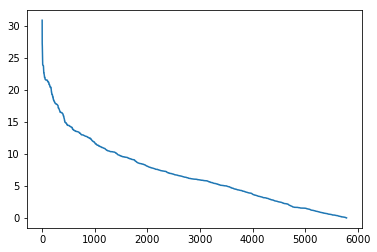

In [36]:
plt.plot(np.arange(len(corr_df.values)),100*corr_df.values[:, 1])
plt.show()

In [108]:
corr02 = corr_df[corr_df.corr_value>=0.2]
corr02_col = corr02['col'].values.tolist()
print('get x_train')
print(len(corr02_col))

get x_train
173


In [109]:
x_train = float_df[corr02_col].values

In [110]:
sub_test = test1_df[corr02_col]
sub_test.fillna(sub_test.median(),inplace=True)
x_test = sub_test.values
print('x_train shape:',x_train.shape)
print('x_test shape:',x_test.shape)

/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


x_train shape: (500, 173)
x_test shape: (100, 173)


In [111]:
X = np.vstack((x_train,x_test))
X = preprocessing.scale(X)
x_train = X[0:len(x_train)]
x_test = X[len(x_train):]

In [47]:
from xgboost import XGBRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

In [112]:
trX, vaX, tr_y, va_y = train_test_split(x_train, y_train, test_size=0.2, random_state=6)

In [103]:
#Regression by machinr learn
def MSE_np(y, y_pred):
    return np.mean(np.square(y-y_pred))

In [113]:
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, trX, tr_y, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

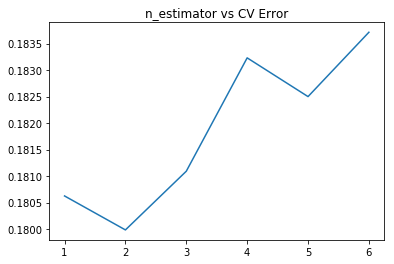

In [114]:
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

In [115]:
model = XGBRegressor(max_depth=2)

In [116]:
model.fit(trX, tr_y)
vap = model.predict(vaX)
print(MSE_np(vap, va_y))

0.0299394232334


In [82]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [83]:
subA = model.predict(x_test)

In [84]:
sub_df = pd.read_csv('测试A-答案模板.csv',header=None)
sub_df['Y'] = subA
sub_df.to_csv('github.csv',header=None,index=False)